# Early Detect Parkinson’s disease by analysing hand drawings and hand writings

## Setup

In [ ]:
#Get to know about the corrent version of pytorch
import torch
print(torch.__version__)

1.12.0+cu113


In [ ]:
# Get to know about cuda device name
torch.cuda.get_device_name(0)

'Tesla T4'

In [ ]:
# Tesla gpu configeration
!nvidia-smi

Fri Jul 15 05:05:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Install fastai latest library
!pip install fastai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# mount the file to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import Dataset

In [ ]:
# Set the root and base path to get the iomage data
root_dir = "/content/drive/MyDrive/Final_Project_Implementation"
base_dir = root_dir + '/Final_Dataset'

In [ ]:
# Automatically reload all changed code of IPython
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
# Import useful packages
from fastai.vision import *
from fastai.metrics import *
from fastai.vision.all import *
from fastai.data.core import DataLoaders
import matplotlib.pyplot as plt

In [ ]:
import numpy as np # linear algebra
np.random.seed(7)

### Looking at the Data and Data Augmentation using DataLoaders

In [ ]:
# Image data augmentation to increse the dataset image count
aug_tfms = aug_transforms(mult=1.5, 
                          do_flip=True, 
                          flip_vert=True, 
                          max_rotate=180.0, 
                          max_lighting=0.3, 
                          max_warp=0.2, 
                          p_affine=0.75, 
                          p_lighting=0.65, 
                          xtra_tfms=None,  
                          mode='bilinear', 
                          pad_mode='reflection', 
                          batch=False, 
)

In [ ]:
# Loading and augment images( size 256 )
data = ImageDataLoaders.from_folder(base_dir, valid='test', bs=8, item_tfms=Resize(256), batch_tfms=[*aug_tfms, Normalize.from_stats(*imagenet_stats)])

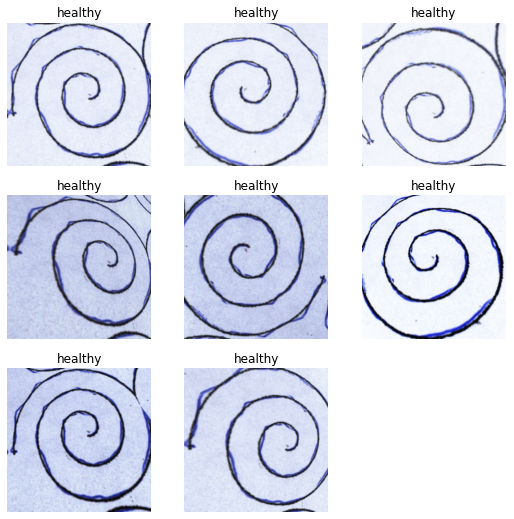

In [ ]:
# Show the input dataset
data.show_batch(max_n=12, nrows=3, unique=True)

In [ ]:
# Show the image label
data.vocab

['healthy', 'parkinson']

In [ ]:
# Print the train and test image data count
print(f"""Training Dataset Length: {len(data.train_ds)}\n
Validation Dataset Length: {len(data.valid_ds)}""")

Training Dataset Length: 1040

Validation Dataset Length: 453


### Training: resnet152

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:287: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://downlo

  0%|          | 0.00/230M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,time
0,0.895592,0.552321,0.788079,06:09
1,0.745933,0.612086,0.796910,00:36
2,0.771467,0.471157,0.807947,00:36
3,0.692007,0.598811,0.845475,00:36
4,0.600971,0.495483,0.807947,00:36
5,0.532606,0.390177,0.847682,00:36
6,0.474965,0.421074,0.854305,00:36
7,0.464003,0.338265,0.834437,00:36
8,0.398070,0.435769,0.836645,00:36
9,0.437803,0.398588,0.830022,00:36


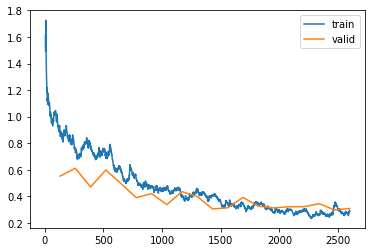

In [ ]:
# Training the model using resnet152 classifier algorithem
learn = cnn_learner(data, models.resnet152, metrics=accuracy, opt_func=Adam).to_fp32()
learn.fit_one_cycle(20);
learn.recorder.plot_loss()

SuggestedLRs(valley=0.0002290867705596611)

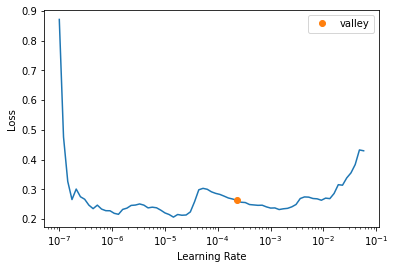

In [ ]:
# Plots lr vs loss relationship using Learning rate finder
learn.lr_find()

### Unfreezing, fine-tuning, and learning rates

In [ ]:
# unferrze the previous model and train the last layer
learn.unfreeze()
learn.fit_one_cycle(20, lr_max=1e-04)

epoch,train_loss,valid_loss,accuracy,time
0,0.301447,0.326581,0.865342,00:49
1,0.293951,0.318940,0.865342,00:48
2,0.348689,0.323333,0.860927,00:48
3,0.394463,0.358165,0.841060,00:48
4,0.438018,0.429900,0.841060,00:48
5,0.398496,0.378202,0.832230,00:49
6,0.372315,0.468766,0.830022,00:48
7,0.371301,0.609375,0.766004,00:48
8,0.373250,0.387385,0.830022,00:48
9,0.381316,0.337244,0.830022,00:48


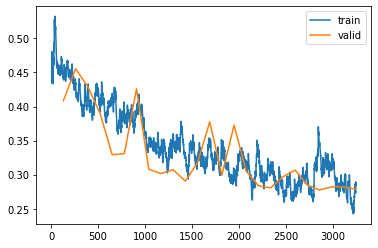

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# Save the model
learn.save('stage-1')

Path('/content/drive/MyDrive/Final_Project_Implementation/Final_Dataset/models/stage-1.pth')

In [ ]:
# Interpret the model's performance
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

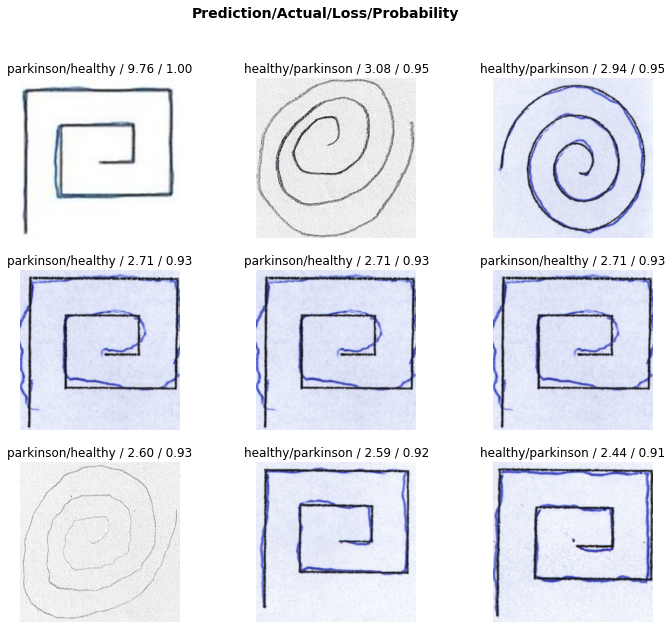

In [ ]:
# See the top losses
interp.plot_top_losses(9, figsize=(12,10))

In [ ]:
# Train the midel again using the size of 512px image with the help of preivous model
data = ImageDataLoaders.from_folder(base_dir, valid='test', bs=8, item_tfms=Resize(512), batch_tfms=[*aug_tfms, Normalize.from_stats(*imagenet_stats)])
learn = cnn_learner(data, models.resnet152, metrics=accuracy, opt_func=Adam).to_fp32()
learn.load('stage-1') # Loading the weights of the previous model
learn.fit(20)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:287: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy,time
0,0.337920,0.396216,0.849890,01:53
1,0.381077,0.350855,0.856512,01:52
2,0.322381,2.232027,0.825607,01:52
3,0.310879,9.577548,0.823400,01:52
4,0.361678,1.793649,0.836645,01:52
5,0.314132,1.041144,0.838852,01:52
6,0.301956,0.740970,0.863135,01:52
7,0.292662,1.047602,0.849890,01:52
8,0.252333,0.542376,0.863135,01:52
9,0.316883,0.590535,0.854305,01:52


In [ ]:
learn = cnn_learner(data, models.resnet152, metrics=accuracy, opt_func=Adam).to_fp32()
learn.fit_one_cycle(20)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:287: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy,time
0,0.970890,0.749460,0.803532,01:54
1,0.698623,0.673647,0.825607,01:53
2,0.716098,0.474199,0.821192,01:53
3,0.616588,0.510589,0.845475,01:53
4,0.530580,0.576632,0.799117,01:53
5,0.464164,0.510284,0.845475,01:53
6,0.437198,0.659759,0.781457,01:53
7,0.463107,0.419768,0.836645,01:53
8,0.437060,0.364120,0.849890,01:53
9,0.333198,0.383798,0.821192,01:53


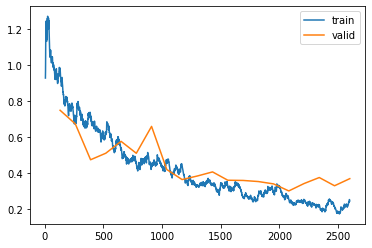

In [ ]:
learn.recorder.plot_loss()

SuggestedLRs(valley=0.00019054606673307717)

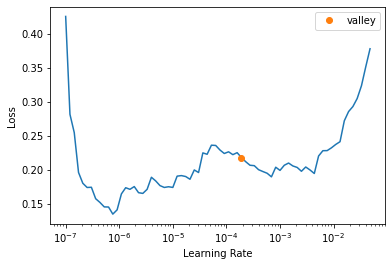

In [ ]:
learn.lr_find()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(20, lr_max=slice(1e-04, 1e-03/5))

epoch,train_loss,valid_loss,accuracy,time
0,0.247849,0.350585,0.871965,02:29
1,0.342588,0.333198,0.880795,02:29
2,0.395836,0.376620,0.849890,02:30
3,0.434349,0.440119,0.801324,02:30
4,0.415603,0.599518,0.825607,02:29
5,0.395438,0.391024,0.823400,02:29
6,0.389001,0.472631,0.841060,02:29
7,0.426523,0.408028,0.799117,02:29
8,0.371841,0.579761,0.726269,02:29
9,0.369018,0.343023,0.843267,02:29


In [ ]:
learn.save('stage-2')

Path('/content/drive/MyDrive/Final_Project_Implementation/Final_Dataset/models/stage-2.pth')

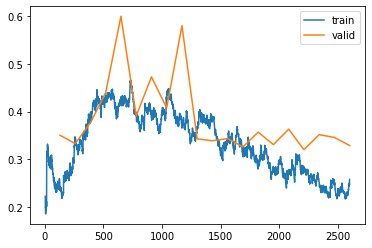

In [ ]:
learn.recorder.plot_loss()

SuggestedLRs(valley=3.311311274956097e-06)

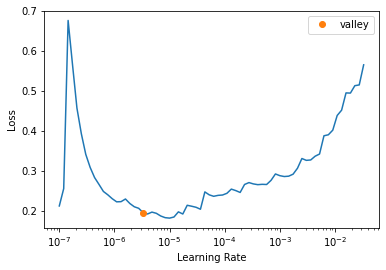

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(20, lr_max=slice(1e-06, 1e-05))

epoch,train_loss,valid_loss,accuracy,time
0,0.304865,0.336734,0.876380,02:20
1,0.299917,0.340227,0.876380,02:25
2,0.276207,0.354118,0.863135,02:27
3,0.251642,0.345061,0.871965,02:27
4,0.254088,0.348354,0.869757,02:28
5,0.263502,0.348810,0.869757,02:28
6,0.262914,0.349907,0.869757,02:28
7,0.271179,0.339944,0.878587,02:27
8,0.278769,0.335267,0.880795,02:28
9,0.251437,0.352161,0.869757,02:28


### Deploying the Model

In [ ]:
# Save the final model
learn.save('stage-2-rn152-512-final')

Path('/content/drive/MyDrive/Final_Project_Implementation/Final_Dataset/models/stage-2-rn152-512-final.pth')

In [ ]:
# Save the model as a pickle file
learn.export('parkinson-predictor.pkl')

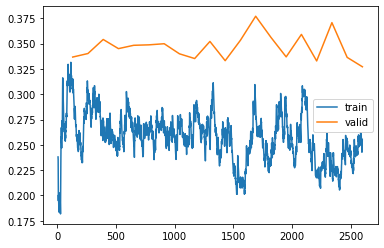

In [ ]:
learn.recorder.plot_loss()

### Result

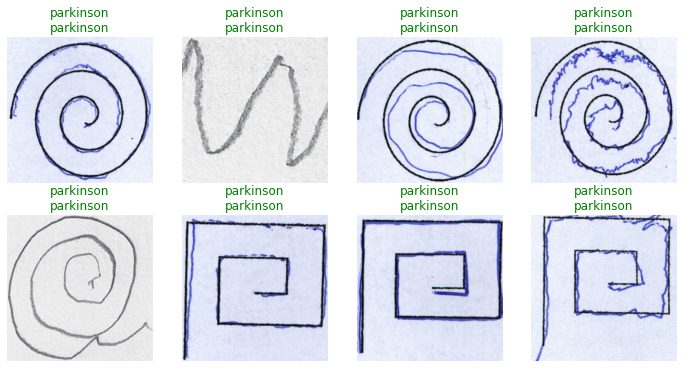

In [ ]:
# Show the result of prediction using the test data
learn.show_results()

### Inference

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

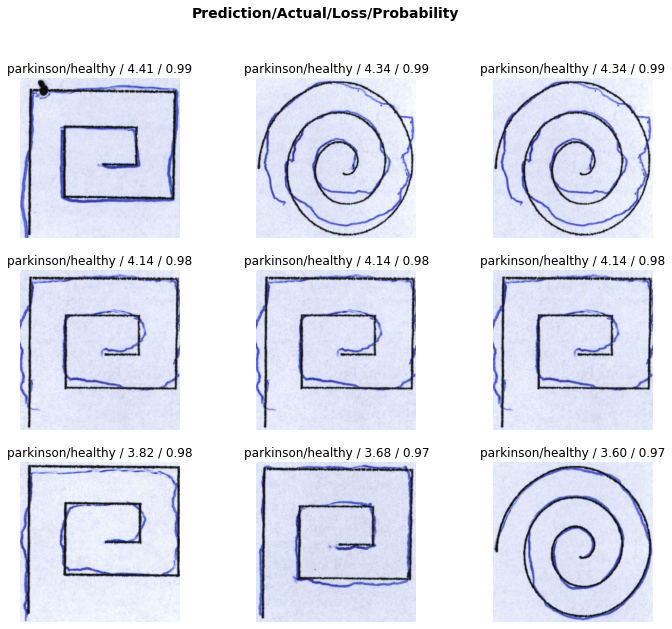

In [ ]:
# See the top losses
interp.plot_top_losses(9, figsize=(12,10))

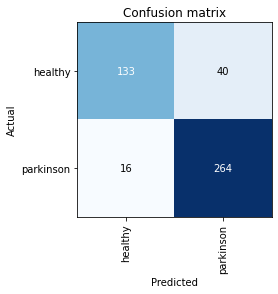

In [ ]:
# Visualise the confusion metrix
interp.plot_confusion_matrix()
plt.savefig("confusion_matrix.png", bbox_inches='tight', padding=0)

In [ ]:
interp.print_classification_report()

              precision    recall  f1-score   support

     healthy       0.89      0.77      0.83       173
   parkinson       0.87      0.94      0.90       280

    accuracy                           0.88       453
   macro avg       0.88      0.86      0.87       453
weighted avg       0.88      0.88      0.87       453



In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.most_confused(min_val=2)

[('healthy', 'parkinson', 40), ('parkinson', 'healthy', 16)]